In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm_notebook

import fannypack
from lib import panda_datasets, panda_baseline_models, panda_baseline_training, omnipush_datasets
from lib.ekf import KalmanFilterNetwork
from fannypack import utils
from lib import dpf
from lib.panda_models import PandaDynamicsModel, PandaEKFMeasurementModel
from lib.fusion import CrossModalWeights
import lib.panda_kf_training as training
from lib.fusion import KalmanFusionModel



In [8]:
# Experiment configuration
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [28]:
experiment_names = [ "fusion_weighted_1", "fusion_poe_1", "fusion_sigma_1"]
fusion_type = ["weighted", "poe", "sigma"]


In [10]:
eval_trajectories = omnipush_datasets.load_trajectories(
    ("/juno/group/fusion_filtering/omnipush_data/simpler/val.hdf5", 10),
    **dataset_args
)

# eval_trajectories = eval_trajectories[70:90]

In [42]:
# image_modality_model
image_measurement = PandaEKFMeasurementModel(missing_modalities=['gripper_sensors'], units=64)
image_dynamics = PandaDynamicsModel(use_particles=False)
image_model = KalmanFilterNetwork(image_dynamics, image_measurement)

# force_modality_model
force_measurement = PandaEKFMeasurementModel(missing_modalities=['image'], units=64)
force_dynamics = PandaDynamicsModel(use_particles=False)
force_model = KalmanFilterNetwork(force_dynamics, force_measurement)

weight_model = CrossModalWeights()

fusion_models = []
buddies = []

for i, f_type in enumerate(fusion_type):
    model = KalmanFusionModel(image_model, force_model, weight_model, fusion_type=f_type)
    buddy = fannypack.utils.Buddy(experiment_names[i],
                                  model,
                                optimizer_names=["im_meas", "force_meas",
                                "im_dynamics", "force_dynamics",
                                "force_ekf", "im_ekf",
                                "fusion"],
                                  load_checkpoint=True,
                                  )
    buddy.load_checkpoint("phase_4_fusion")
    fusion_models.append(model)
    buddies.append(buddy)



[buddy-fusion_weighted_1] Using device: cuda
[buddy-fusion_weighted_1] Read checkpoint from path: checkpoints/fusion_weighted_1-0000000000023626.ckpt


/scr-ssd/filter/fannypack/fannypack/utils/_buddy_mixins/_checkpointing.py:252: UserWarning: Checkpoint loading: overriding optimizer names.
  warnings.warn("Checkpoint loading: overriding optimizer names.")


[buddy-fusion_weighted_1] Loaded checkpoint at step: 23626
[buddy-fusion_weighted_1] Read checkpoint from path: checkpoints/fusion_weighted_1-phase_4_fusion.ckpt
[buddy-fusion_weighted_1] Loaded checkpoint at step: 23626
[buddy-fusion_poe_1] Using device: cuda
[buddy-fusion_poe_1] Read checkpoint from path: checkpoints/fusion_poe_1-0000000000023626.ckpt
[buddy-fusion_poe_1] Loaded checkpoint at step: 23626
[buddy-fusion_poe_1] Read checkpoint from path: checkpoints/fusion_poe_1-phase_4_fusion.ckpt
[buddy-fusion_poe_1] Loaded checkpoint at step: 23626
[buddy-fusion_sigma_1] Using device: cuda
[buddy-fusion_sigma_1] Read checkpoint from path: checkpoints/fusion_sigma_1-0000000000023626.ckpt
[buddy-fusion_sigma_1] Loaded checkpoint at step: 23626
[buddy-fusion_sigma_1] Read checkpoint from path: checkpoints/fusion_sigma_1-phase_4_fusion.ckpt
[buddy-fusion_sigma_1] Loaded checkpoint at step: 23626


In [46]:
pred, actual = training.rollout_fusion(fusion_models[0], eval_trajectories, 
                                   true_initial=True, init_state_noise=0.0, save_data_name="test1")

/scr-ssd/miniconda3/envs/filter/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


<HDF5 dataset "actual_states": shape (10, 50, 2), type "<f8">
<HDF5 dataset "force_betas": shape (10, 50, 2), type "<f8">
<HDF5 dataset "force_states": shape (10, 50, 2), type "<f4">
<HDF5 dataset "image_betas": shape (10, 50, 2), type "<f8">
<HDF5 dataset "image_states": shape (10, 50, 2), type "<f4">
<HDF5 dataset "predicted_sigmas": shape (10, 50, 2, 2), type "<f4">
<HDF5 dataset "predicted_states": shape (10, 50, 2), type "<f4">


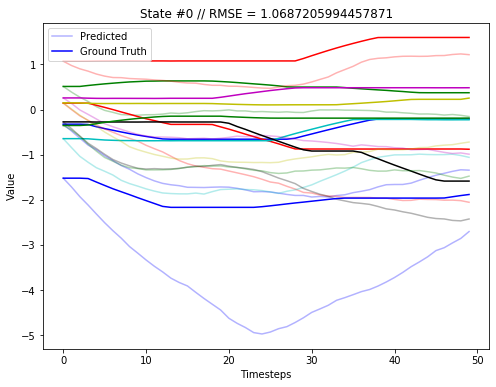

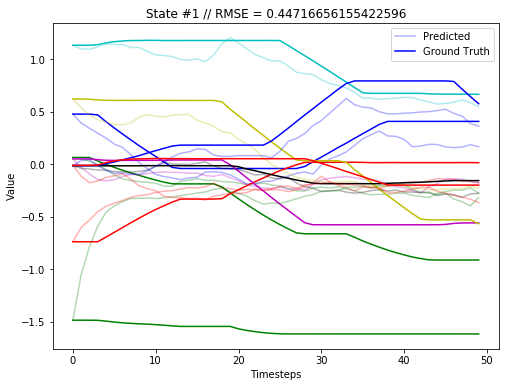

In [30]:
pred_list = []
actual_list = []

Fusion Model: weighted


No handles with labels found to put in legend.


(10, 50, 2)


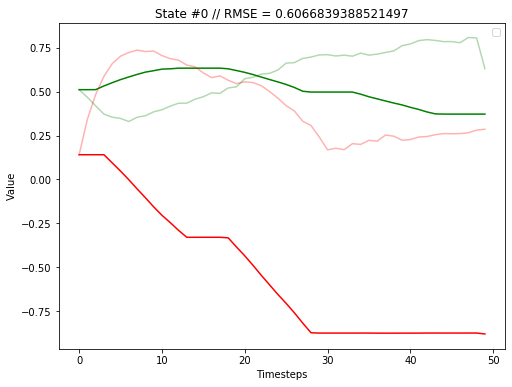

No handles with labels found to put in legend.


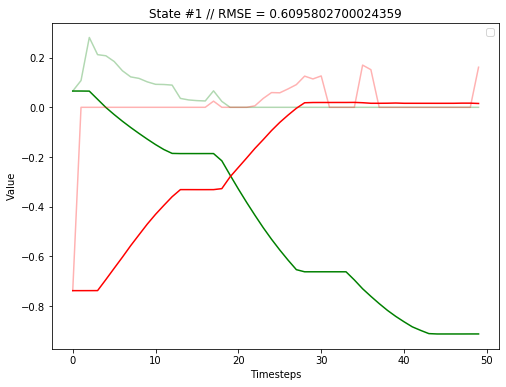


Fusion Model: poe


No handles with labels found to put in legend.


(10, 50, 2)


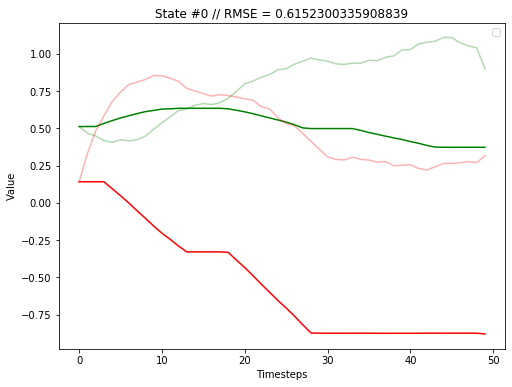

No handles with labels found to put in legend.


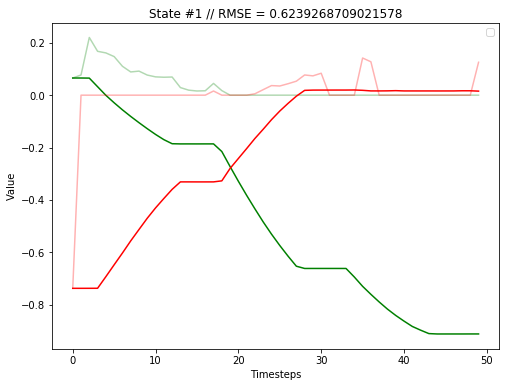


Fusion Model: sigma


No handles with labels found to put in legend.


(10, 50, 2)


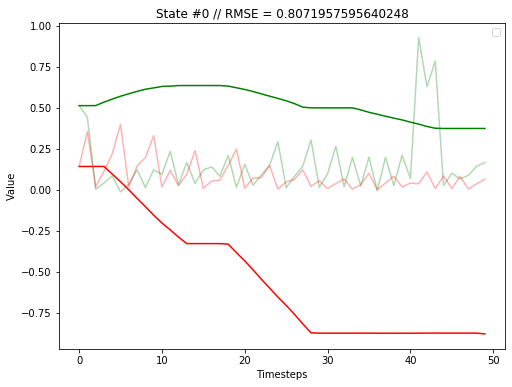

No handles with labels found to put in legend.


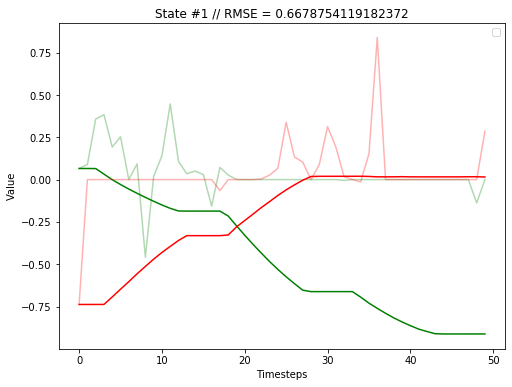

In [38]:
for i in range(len(fusion_models)):
    print("Fusion Model: {}".format(fusion_type[i])) 
    pred, actual = training.rollout_kf(fusion_models[i], eval_trajectories, 
                                       true_initial=True, init_state_noise=0.0)
    pred_list.append(pred)
    actual_list.append(actual)
    training.eval_rollout(pred, actual, plot=True, plot_traj=[1,2])
    print("")

No handles with labels found to put in legend.


0


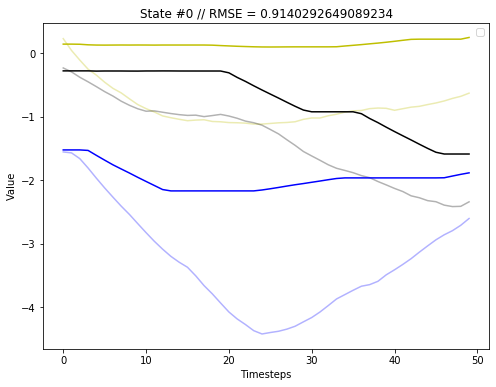

No handles with labels found to put in legend.


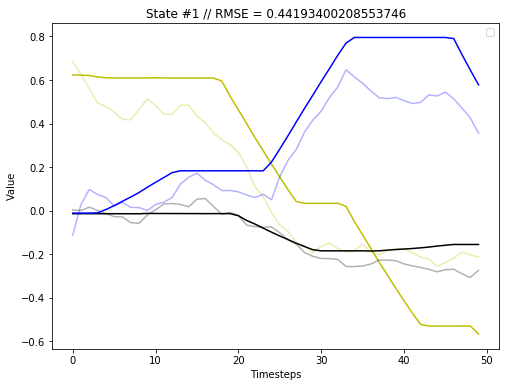

No handles with labels found to put in legend.


1


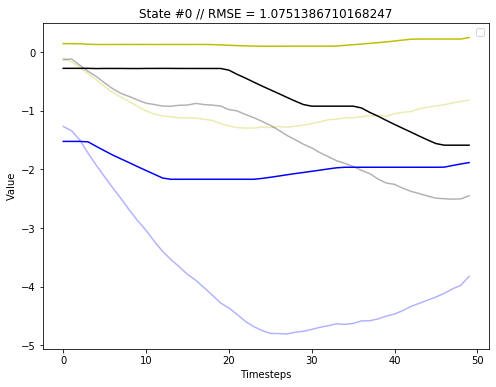

No handles with labels found to put in legend.


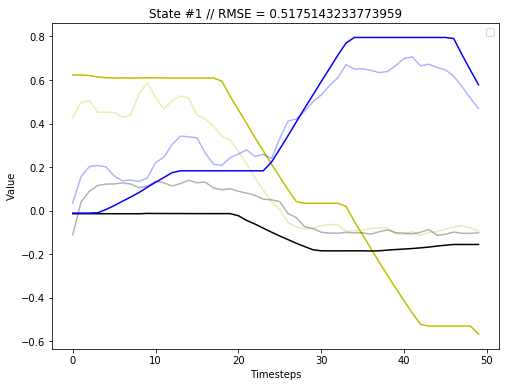

No handles with labels found to put in legend.


2


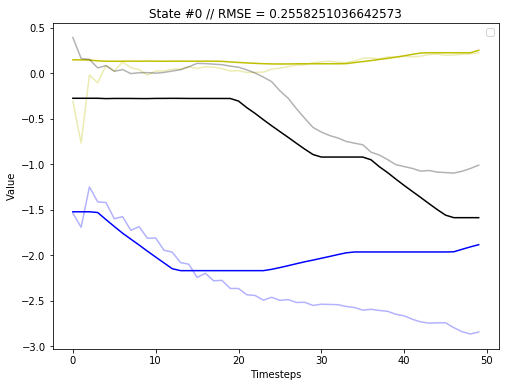

No handles with labels found to put in legend.


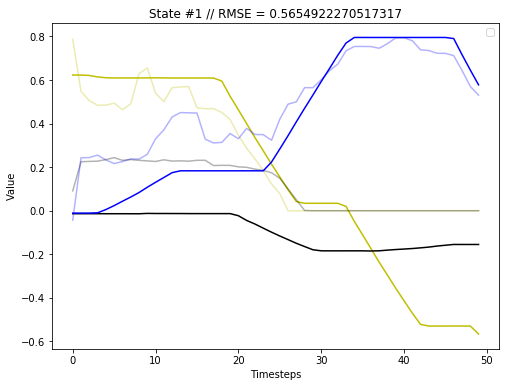

No handles with labels found to put in legend.


3


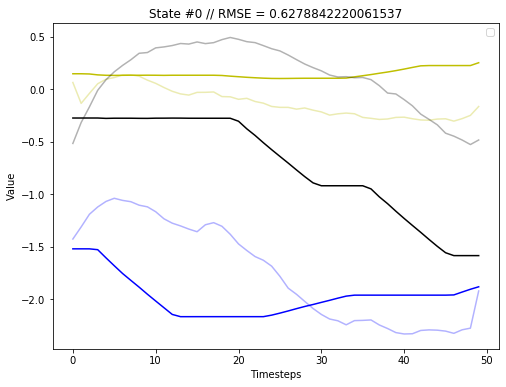

No handles with labels found to put in legend.


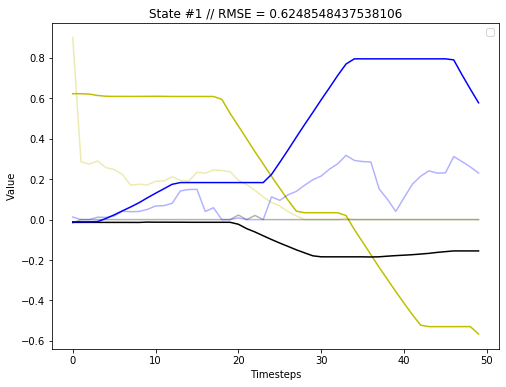

No handles with labels found to put in legend.


4


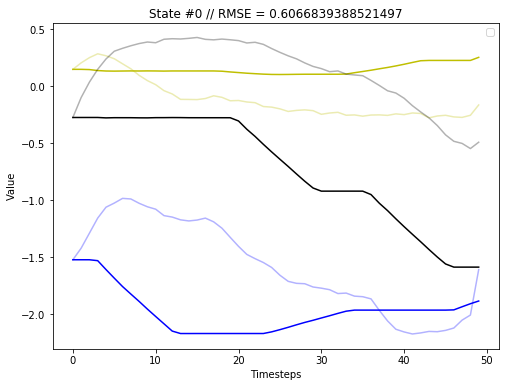

No handles with labels found to put in legend.


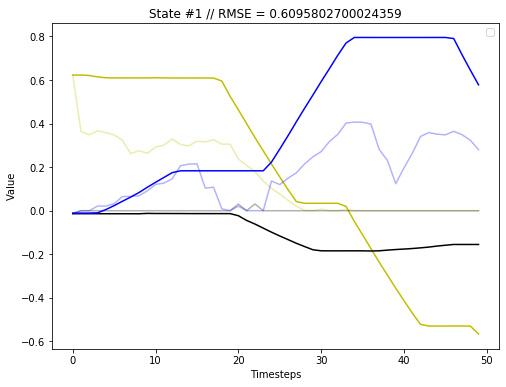

No handles with labels found to put in legend.


5


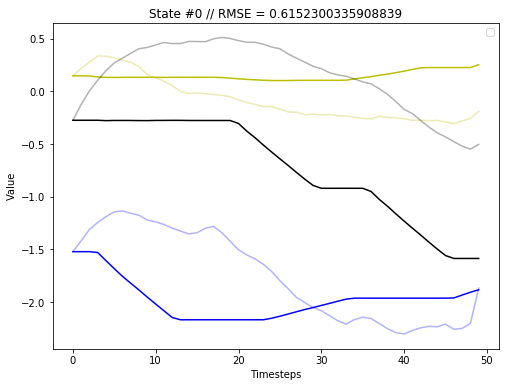

No handles with labels found to put in legend.


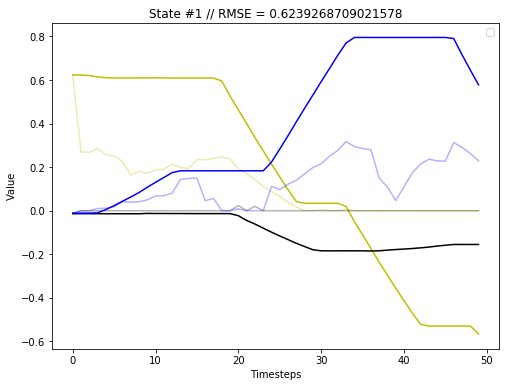

No handles with labels found to put in legend.


6


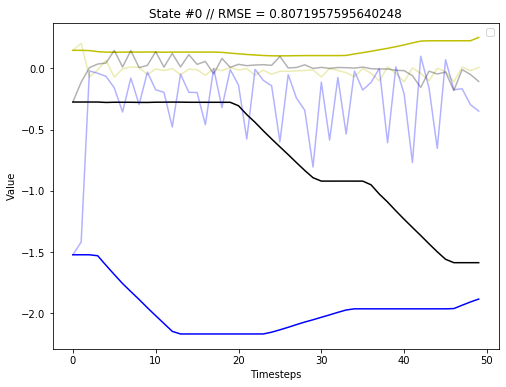

No handles with labels found to put in legend.


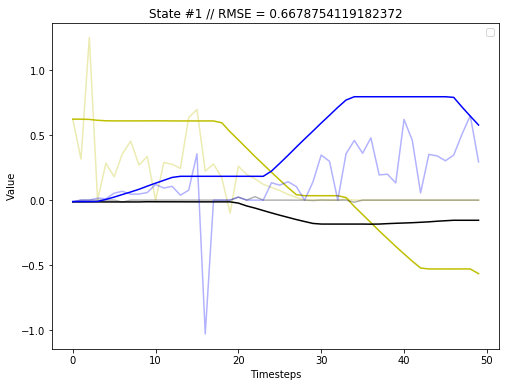

In [40]:
for i, (pred, actual) in enumerate(
                    zip(pred_list, actual_list)):
    print(i)
#     print(experiment_names[i])
    training.eval_rollout(pred, actual, plot=True, plot_traj=[5,6,7])

In [31]:

# for i in range(len(fusion_models)):
#     buddies[i].load_checkpoint("phase_4_fusion")

#     print("Fusion Model: {}".format(fusion_type[i])) 
#     pred, actual = training.rollout_kf(fusion_models[i], eval_trajectories, true_initial=True, init_state_noise=0.2)
#     training.eval_rollout(pred, actual, plot=True)
#     print("")

In [18]:
experiment_name = "ekf_omnipush_2"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}
measurement = PandaEKFMeasurementModel(units=32)
dynamics = PandaDynamicsModel(use_particles=False)
ekf = KalmanFilterNetwork(dynamics, measurement)
print("Creating model...")
buddy = fannypack.utils.Buddy(experiment_name,
                              ekf,
                              optimizer_names=["ekf", "dynamics", "measurement"],
                              load_checkpoint=True,
                              )

buddy.load_checkpoint("phase_3_e2e")

Creating model...
[buddy-ekf_omnipush_2] Using device: cuda
[buddy-ekf_omnipush_2] Read checkpoint from path: checkpoints/ekf_omnipush_2-0000000000005053.ckpt
[buddy-ekf_omnipush_2] Loaded checkpoint at step: 5053
[buddy-ekf_omnipush_2] Read checkpoint from path: checkpoints/ekf_omnipush_2-phase_3_e2e.ckpt
[buddy-ekf_omnipush_2] Loaded checkpoint at step: 5053


True

(10, 50, 2)


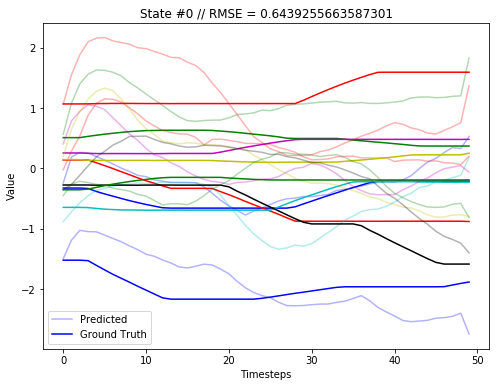

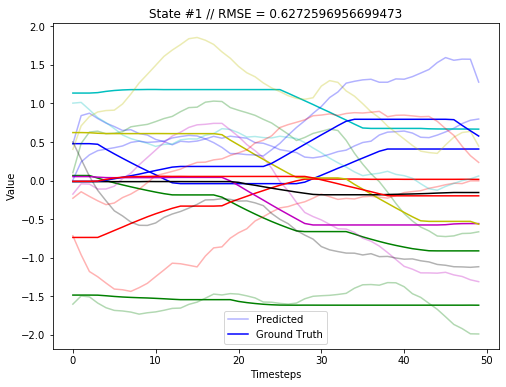

In [19]:
pred, actual = training.rollout_kf(ekf, eval_trajectories, true_initial=True, init_state_noise=0.2)
training.eval_rollout(pred, actual, plot=True)